### Import potrzebnych bibliotek

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Przygotowanie danych

### Wczytanie danych

In [3]:
datapath = Path("d:/mw_wdum/wdum") / "data" / "housing"
housing = pd.read_csv(datapath / "housing.csv")
np.random.seed(42)
# housing["ocean_proximity"].value_counts() liczy występowanie w kategorii
# housing.describe() opisuje statystycznie
# housing.describe(include=object)

### Przegląd danych

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.describe(include=object)

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


### Histogramy danych

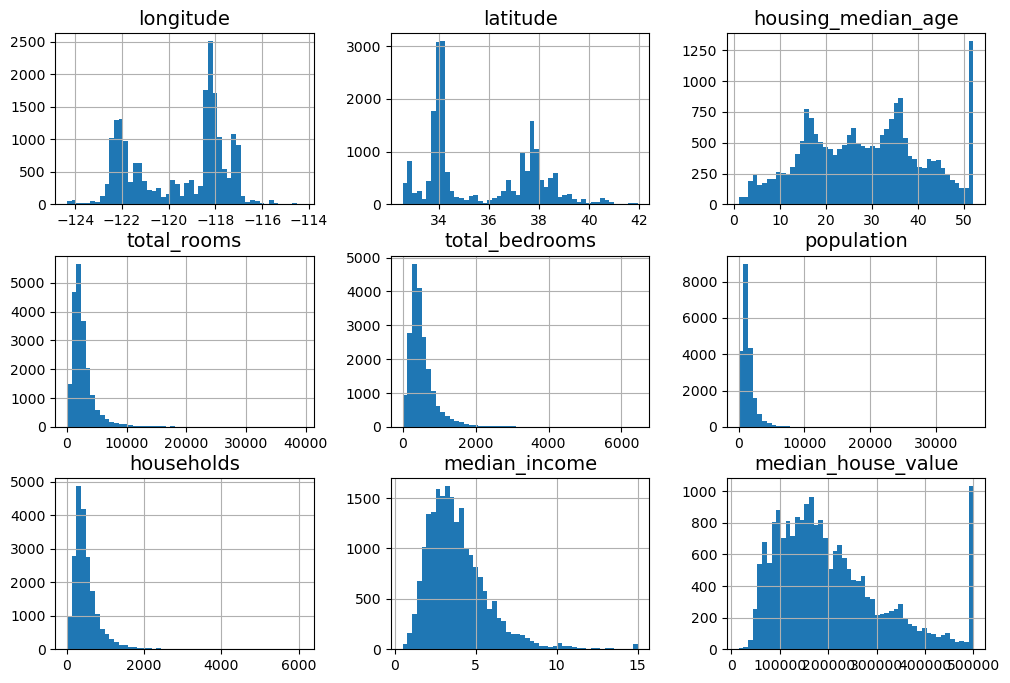

In [8]:
housing.hist(bins=50, figsize=(12, 8)) # pokazują 
plt.show()

### Tworzenie zbioru testowego

#### Tworzenie histogramów przemapowanej kategorii dochodów

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

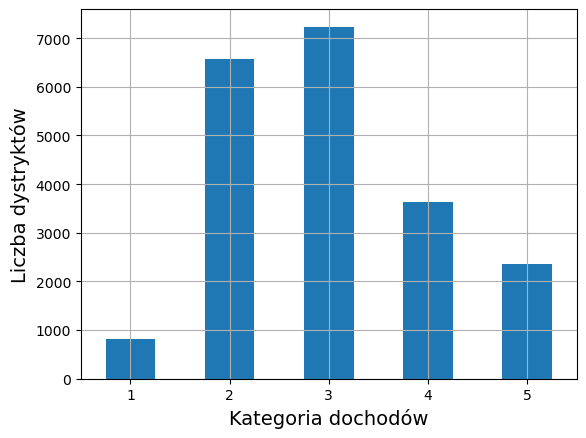

In [10]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Kategoria dochodów")
plt.ylabel("Liczba dystryktów")
plt.show()

#### Tworzenie zbiorów testowych

In [11]:
df_train_rand_samp, df_test_rand_samp = train_test_split(
        housing, test_size=0.2, random_state=42)
df_train, df_test = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"],random_state=42)

#### Porównanie podziałów wewnątrz zbiorów

In [12]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

compare_samp = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(df_test),
    "Random %": income_cat_proportions(df_test_rand_samp),
}).sort_index()
compare_samp.index.name = "Income Category"
compare_samp["Strat. Error %"] = (compare_samp["Stratified %"] /
                                   compare_samp["Overall %"] - 1)
compare_samp["Rand. Error %"] = (compare_samp["Random %"] /
                                  compare_samp["Overall %"] - 1)
(compare_samp * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


### Wizualizacja danych

In [13]:
for set_ in (df_train, df_test):
    set_.drop("income_cat", axis=1, inplace=True)

##### Bazowy wykres rozkładu geograficznego danych

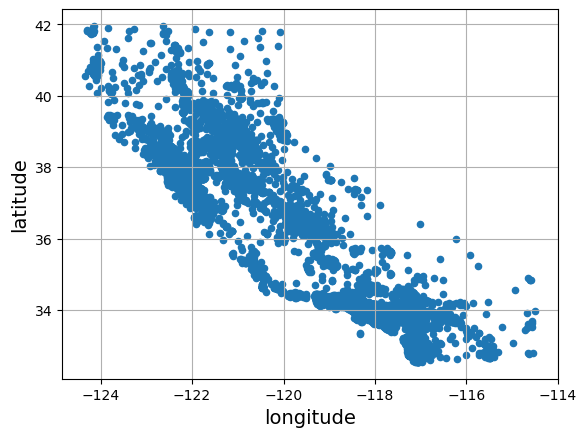

In [14]:
df_train_eda = df_train.copy()
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show() #

##### Wykres punktowy częstotliwości występowania

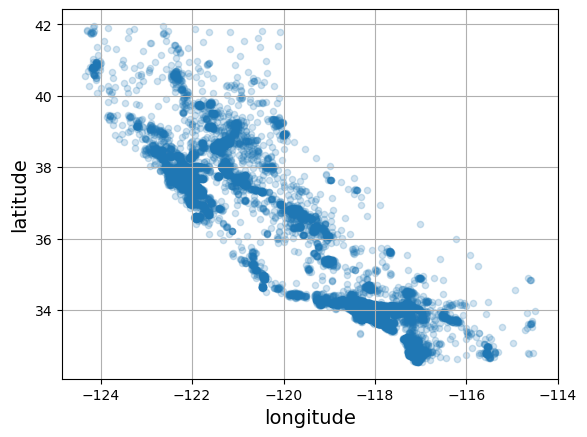

In [15]:
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

##### Wykres punktowy częstotliwości z skalą kolorystyczną

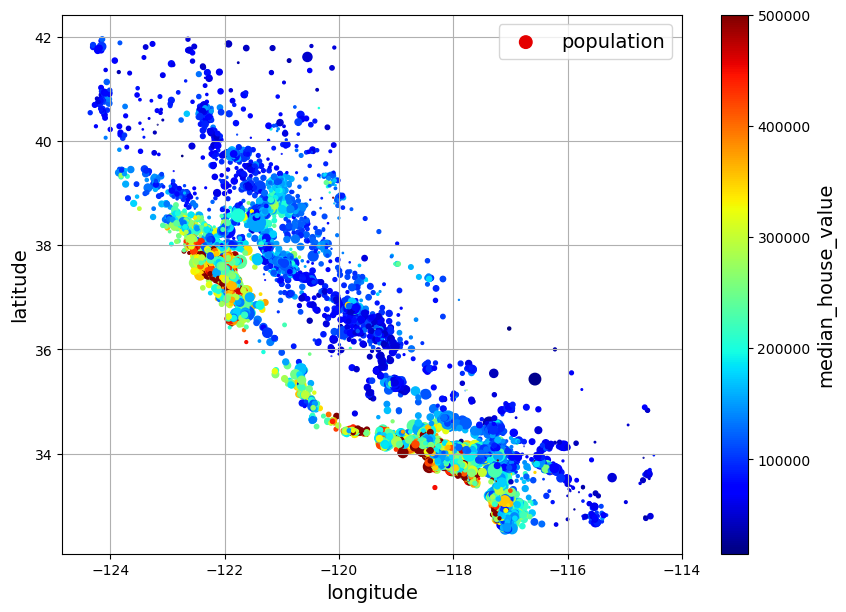

In [16]:
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=df_train_eda["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

##### Wykres finalny z nałożoną mapą

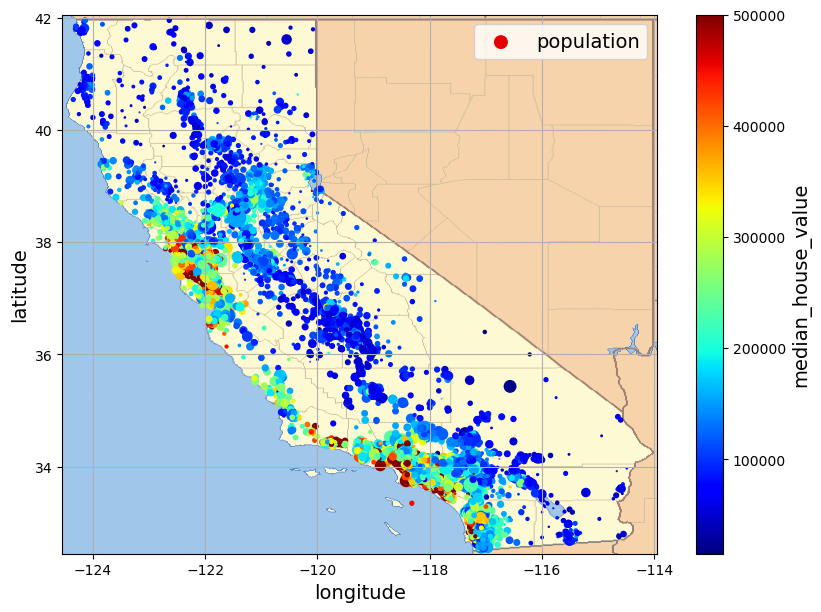

In [17]:
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=df_train_eda["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(datapath / "california.png")
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

### Korelacja między zmiennymi

In [18]:
corr_matrix = df_train_eda.select_dtypes(np.number).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

#### Scatter chart zmiennych

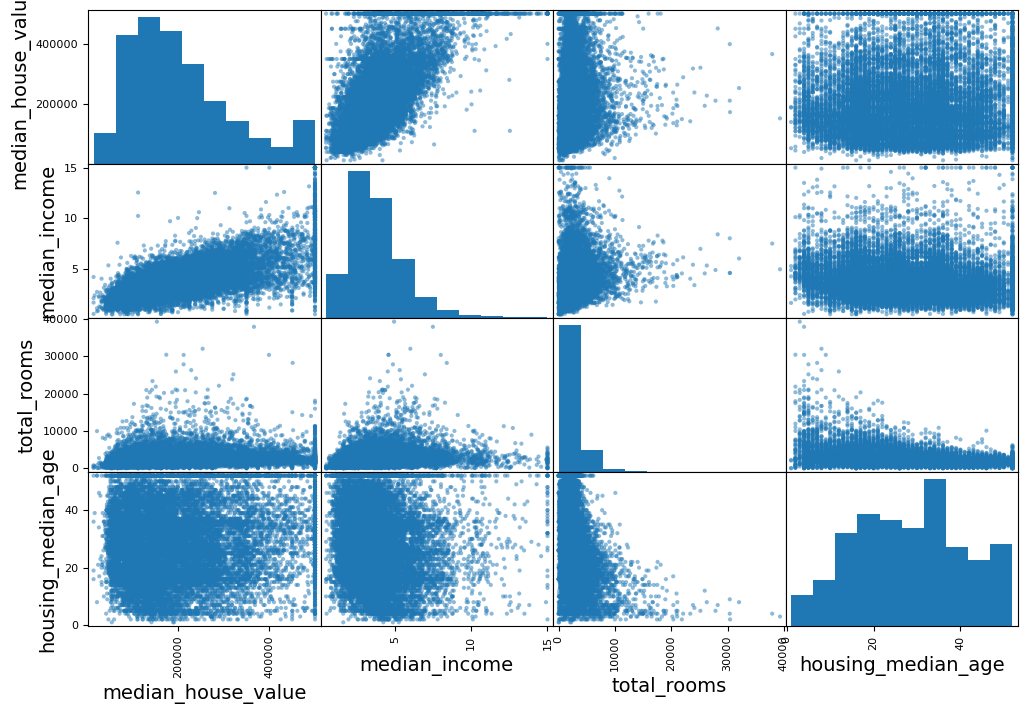

In [19]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(df_train_eda[attributes], figsize=(12, 8))
plt.show()

#### Heatmap chart median_house_value and median_income

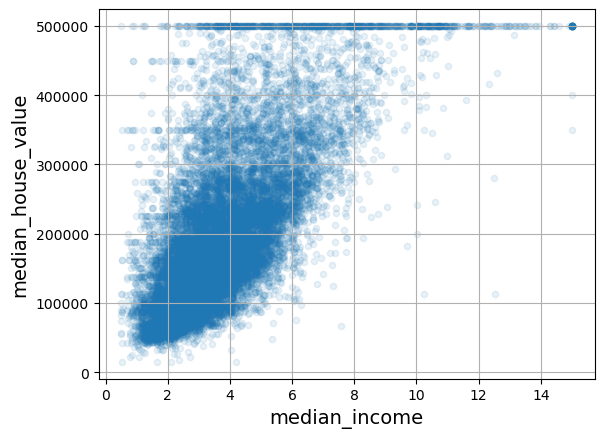

In [20]:
df_train_eda.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

#### Współczynniki korelacji

In [21]:
df_train_eda["rooms_per_house"] = df_train_eda["total_rooms"] / df_train_eda["households"]
df_train_eda["bedrooms_ratio"] = df_train_eda["total_bedrooms"] / df_train_eda["total_rooms"]
df_train_eda["people_per_house"] = df_train_eda["population"] / df_train_eda["households"]

corr_matrix = df_train_eda.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

## Uczenie maszynowe

#### Przygotowanie zbiorów do uczenia maszynowego

In [22]:
x_train = df_train.drop("median_house_value", axis=1)
y_train = df_train["median_house_value"].copy()

In [23]:
df_train.isna().sum() #pokazuje liczbę pustych wartości

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

#### Usunięcie pustych wartości

In [24]:
null_rows_idx = x_train.isnull().any(axis=1)
x_train.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


#### Usuniecie całych wierszy

In [25]:
x_train_option1 = x_train.copy()
x_train_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1
x_train_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


#### Usunięcie całej kolumny

In [26]:
x_train_option2 = x_train.copy()
x_train_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2
x_train_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


#### Zastąpienie pustych wartości medianą

In [27]:
x_train_option3 = x_train.copy()
median = x_train["total_bedrooms"].median()
x_train_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3
x_train_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


### Przygotowanie danych do trenowania

#### Podstawowy imputer

In [74]:
imputer = SimpleImputer(strategy="median")
x_train_num = x_train.select_dtypes(include=[np.number])
# x_train_num

imputer.fit(x_train_num)

# przydatne metody
# imputer.statistics_
# x_train_num.median().values
# imputer.feature_names_in_

X = imputer.transform(x_train_num) # wartości x'owe dla imputera podstawowego

In [75]:
x_train_tr = pd.DataFrame(X, columns=x_train_num.columns,
                          index=x_train_num.index)
# x_train_tr
# x_train_tr.loc[null_rows_idx].head() # pięć wierszy po zastąpieniu wierszy medianą


In [30]:
imputer = SimpleImputer(strategy="median").set_output(transform="pandas")
X = imputer.fit_transform(x_train_num)

X = imputer.transform(x_train_num)
# X
# X.loc[null_rows_idx].head() - zamienione puste wiersze strategią mediany

#### Zakodowana macierz kategorii ocean_proximity

In [31]:
x_train_cat = x_train[["ocean_proximity"]]
x_train_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


#### Zakodowane kategorie jako DataFrame

In [32]:
ordinal_encoder = OrdinalEncoder().set_output(transform="pandas")
x_train_cat_encoded = ordinal_encoder.fit_transform(x_train_cat)
x_train_cat_encoded

,ocean_proximity
13096,3.0
14973,0.0
3785,1.0
14689,1.0
20507,4.0
...,...
14207,0.0
13105,1.0
19301,4.0
19121,0.0


#### Zakodowane kategorie z użyciem OneHotEncoder'a w formie macierzy

In [33]:
one_hot_encoder = OneHotEncoder().set_output(transform="default")
cat_encoded_default = one_hot_encoder.fit_transform(x_train_cat)
cat_encoded_default.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

#### Zakodowane dane w formie DataFrame ( z użyciem kodowania vektorowego)

In [34]:
cat_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
cat_encoded = cat_encoder.fit_transform(x_train_cat)
cat_encoded

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
14207,1.0,0.0,0.0,0.0,0.0
13105,0.0,1.0,0.0,0.0,0.0
19301,0.0,0.0,0.0,0.0,1.0
19121,1.0,0.0,0.0,0.0,0.0


#### Skalowanie zakresu od -1 do 1

In [35]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
x_train_min_max_scaled = min_max_scaler.fit_transform(x_train_num)
x_train_min_max_scaled.describe() # faktycznie są od -1 do 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000
mean,-0.031060,-0.343033,0.081457,-0.865842,-0.826720,-0.825480,-0.813705,-0.535106
std,0.405806,0.453892,0.493558,0.111160,0.136532,0.134314,0.142940,0.260953
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.482759,-0.706383,-0.333333,-0.926497,-0.904977,-0.903815,-0.896211,-0.715507
50%,0.184584,-0.636170,0.098039,-0.892009,-0.860525,-0.857195,-0.848049,-0.580889
75%,0.286004,0.100000,0.411765,-0.839666,-0.792559,-0.788615,-0.775247,-0.413787
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Standaryzacja danych

In [36]:
standard_scaler = StandardScaler().set_output(transform="pandas")
x_train_num_standard_scaled = standard_scaler.fit_transform(x_train_num)
x_train_num_standard_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.634400e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.837216e-15,-2.580838e-15,-1.473843e-17,-5.916886e-17,2.108500e-17,4.765783e-17,1.463085e-17,7.611267e-17
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000031e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.387765e+00,-1.447452e+00,-2.191210e+00,-1.206927e+00,-1.269200e+00,-1.299382e+00,-1.303343e+00,-1.781577e+00
25%,-1.113124e+00,-8.005453e-01,-8.404335e-01,-5.456668e-01,-5.731971e-01,-5.832443e-01,-5.772176e-01,-6.913383e-01
50%,5.314128e-01,-6.458502e-01,3.359809e-02,-2.354008e-01,-2.476096e-01,-2.361370e-01,-2.402747e-01,-1.754490e-01
75%,7.813423e-01,9.761041e-01,6.692575e-01,2.354897e-01,2.502091e-01,2.744761e-01,2.690575e-01,4.649198e-01
max,2.540847e+00,2.959014e+00,1.861119e+00,1.678576e+01,1.337988e+01,1.359152e+01,1.268893e+01,5.882868e+00


#### Zastosowanie rozkladu logarytmicznego w celu symetryzacji cechy

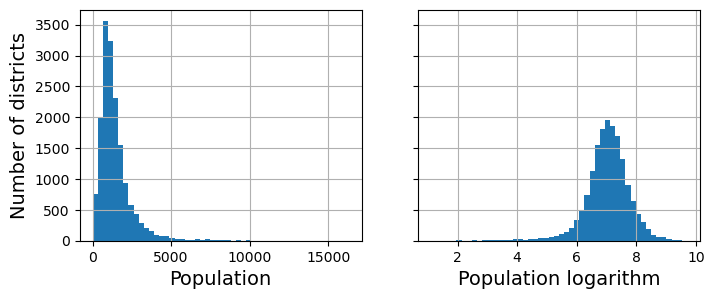

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
x_train["population"].hist(ax=axs[0], bins=50)
x_train["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Population logarithm")
axs[0].set_ylabel("Number of districts")
plt.show()

#### Upewnienie się, żę rozklad po skalowaniu jest w miarę jednostajny

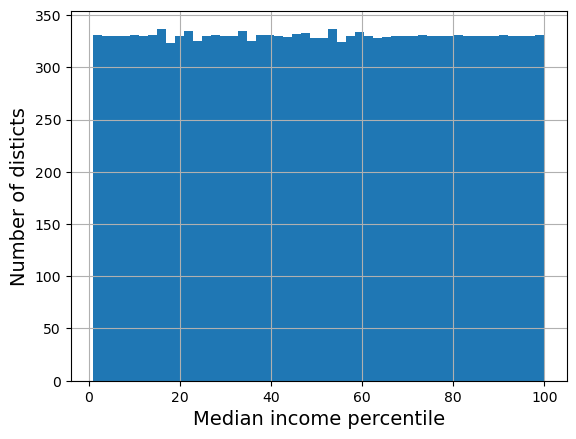

In [38]:
percentiles = [np.percentile(x_train["median_income"], p) for p in range(1, 100)]
x_train["median_income_percentile"] = pd.cut(x_train["median_income"], bins=[-np.inf] + percentiles + [np.inf], labels=range(1, 100 + 1))
x_train["median_income_percentile"] = x_train["median_income_percentile"].astype(int)
x_train["median_income_percentile"].hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of disticts")
plt.show()
x_train.drop("median_income_percentile", axis=1, inplace=True) # usuwamy zmienną poglądową

#### Wizualizacja housing_median_age z różnymi wartościami gamma w funkcji rbf

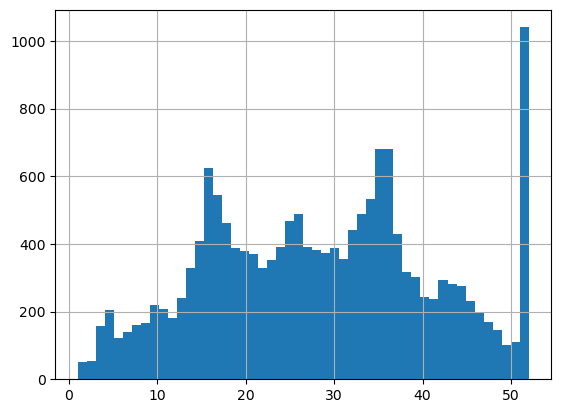

In [39]:
x_train["housing_median_age"].hist(bins=50)

# Tworzymy 2 wersje funkcji rbf z różnymi wartościami gamma
x_train["age_similarity_35_v1"] = rbf_kernel(x_train[["housing_median_age"]], [[35]], gamma=0.1)
x_train["age_similarity_35_v2"] = rbf_kernel(x_train[["housing_median_age"]], [[35]], gamma=0.03)

#### Wizualizacja zastosowania różnego współczynnika gamma w rdf

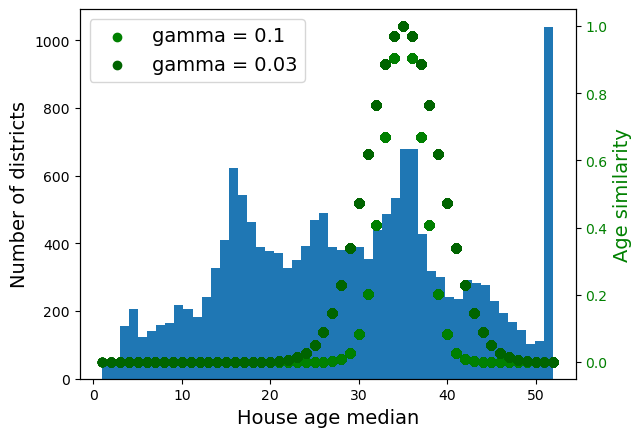

In [40]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("House age median")
ax1.set_ylabel("Number of districts")
ax1.hist(x_train["housing_median_age"], bins=50)

ax2 = ax1.twinx() # tworzy bliźniaczą skalę z tymi samymi wartościami na x
ax2.scatter(x_train["housing_median_age"], x_train["age_similarity_35_v1"], color="green", label="gamma = 0.1")
ax2.scatter(x_train["housing_median_age"], x_train["age_similarity_35_v2"], color="darkgreen", label="gamma = 0.03")
ax2.tick_params(axis="y", labelcolor="green")
ax2.set_ylabel("Age similarity", color="green")
plt.legend(loc="upper left")
plt.show()
x_train.drop(["age_similarity_35_v1", "age_similarity_35_v2"], axis=1, inplace=True) # usuniecie wartości poglądowych

#### Uzycie modelu regresji liniowej do wyliczenia predykcji median_income

In [41]:
target_scalar = StandardScaler()
scaled_labels = target_scalar.fit_transform(y_train.to_frame())

model = LinearRegression()
model.fit(x_train[["median_income"]], scaled_labels)
some_new_data = x_train[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scalar.inverse_transform(scaled_predictions)

#### Alternatywne podejscie - TransformedTargetRegressor

In [42]:
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(x_train[["median_income"]], y_train)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

#### `Przykład`: Transformacja wartości populacji z użyciem rozkladu logarytmicznego

In [43]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(x_train[["population"]])
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


#### `Przykład`: Prawdopodobieństwo wieku budynku w okolicy 35 lat

In [46]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_similarity_35 = rbf_transformer.transform(x_train[["housing_median_age"]])
age_similarity_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

#### `Przykład`: Prawdopodobieństwo znajdowania się w San Francisco

In [48]:
sf_cords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_cords], gamma=0.1))
sf_similarity = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_similarity

array([[0.99566482],
       [0.99567518],
       [0.99655196],
       ...,
       [0.6599801 ],
       [0.6752005 ],
       [0.67616077]])

#### `Przykład`: Działania transformera na danych prostych

In [50]:
sample_arr = np.array([[1., 2.], [3., 4.]])
ratio_function = FunctionTransformer(lambda x: x[:, [0]] / x[:, [1]])
ratio = ratio_function.transform(sample_arr)
ratio

array([[0.5 ],
       [0.75]])

#### Implementacja `StandardScalerClone`

In [52]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean
    
    def fit(self, X, y=None):
        X = check_array
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X): 
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

#### Implementacja `ClusterSimilarity`

In [63]:

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.gamma = gamma
        self.n_clusters = n_clusters
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Podobieństwo {i} skupienia" for i in range(self.n_clusters)]

#### Wyliczenie prawdopodobieństwa clustrów

In [65]:
cluster_similarity = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
cluster_similarity
similarities = cluster_similarity.fit_transform(x_train[["latitude", "longitude"]], sample_weight=y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Wynikowa mapa

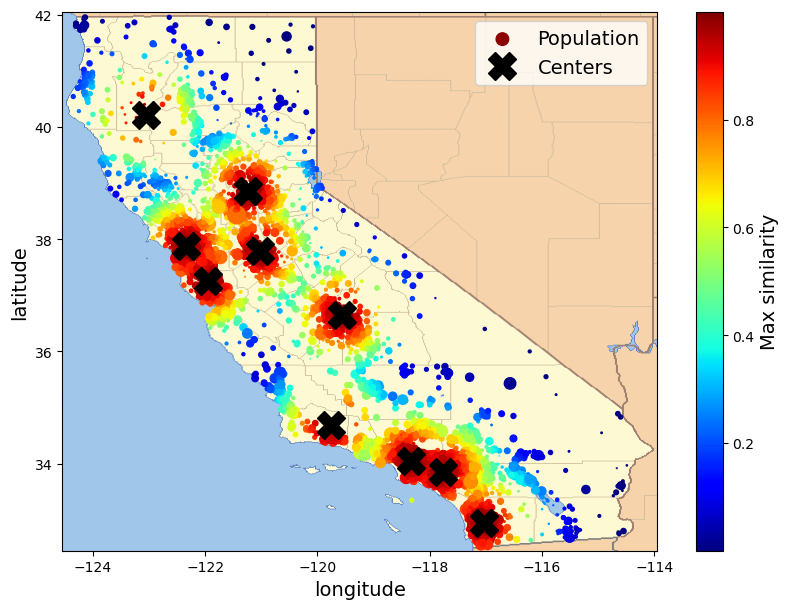

In [69]:
x_train["Max similarity"] = similarities.max(axis=1)
x_train.plot(kind="scatter", x="longitude", y="latitude", s=x_train["population"] / 100, label="Population", c="Max similarity", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.plot(cluster_similarity.kmeans_.cluster_centers_[:, 1], cluster_similarity.kmeans_.cluster_centers_[:, 0], linestyle="", color="black", marker="X", markersize=20, label="Centers")
plt.legend(loc="upper right")
california_img = plt.imread(datapath / "california.png")
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()